# Slide 10 - Concept Algebra

**Pairs shown:** `queen − king`, `woman − man`, `aunt − uncle`  

### How to run
1. (Optional) Install dependencies if needed — see the commented `pip install` cell.
2. Run the **Imports & Config** cell.
3. Run the **Load CLIP and Word2Vec** cell.
4. Run the **Run once** cell to see results for the final layer.
5. Use the **Layer selector (widget)** to change the CLIP transformer layer interactively.

In [1]:
# If you need packages, uncomment and run:
!pip -q install clip-anytorch gensim scikit-learn ipywidgets ftfy regex tqdm

# If you prefer OpenCLIP instead of OpenAI CLIP, uncomment:
# !pip -q install open-clip-torch

In [2]:
from __future__ import annotations

import os
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

# --- CLIP (openai/clip packaged as 'clip-anytorch') ---
import clip  # pip: clip-anytorch

# --- Word2Vec (optional) ---
try:
    import gensim.downloader as api
    from gensim.models import KeyedVectors
except Exception:  # running without gensim installed
    api = None
    KeyedVectors = None

# --- Widgets (optional) ---
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except Exception:
    widgets = None
    display = None
    clear_output = None

# ---------------------------
# Configuration
# ---------------------------
PAIR_STRINGS: List[Tuple[str, str]] = [
    ("queen", "king"),
    ("woman", "man"),
    ("aunt", "uncle"),
]

# Encode the raw word by default; you can change this to e.g. "a photo of a {}"
PROMPT_TEMPLATE: str = "{}"

CLIP_MODEL_NAME: str = "ViT-B/32"
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# Word2Vec options
WORD2VEC_KEY: str = "word2vec-google-news-300"  # requires internet to auto-download
WORD2VEC_LOCAL_PATH: Optional[str] = None       # or set to a local .bin file path

# Derived
WORDS: List[str] = sorted({w for pair in PAIR_STRINGS for w in pair})

In [3]:
@dataclass
class EmbeddingResult:
    vectors: Dict[str, np.ndarray]           # word -> vector
    diffs: Dict[str, np.ndarray]             # "a-b" -> difference vector

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    """Cosine similarity between 1D vectors."""
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def pair_similarity_matrix(diffs: Dict[str, np.ndarray]) -> pd.DataFrame:
    """Cosine similarity matrix across difference vectors."""
    keys = list(diffs.keys())
    M = np.zeros((len(keys), len(keys)), dtype=np.float32)
    for i, ki in enumerate(keys):
        for j, kj in enumerate(keys):
            M[i, j] = cosine_sim(diffs[ki], diffs[kj])
    return pd.DataFrame(M, index=keys, columns=keys)

# ---------------------------
# CLIP utilities
# ---------------------------
def load_clip_model(name: str, device: str):
    """Load CLIP model by name; returns the model in eval mode."""
    model, _ = clip.load(name, device=device, jit=False)
    model.eval()
    return model

def encode_clip_text(model, texts: List[str], layer_idx: Optional[int] = None, device: str = "cpu") -> np.ndarray:
    """
    Encode a list of texts using CLIP's text transformer.
    If layer_idx is None, returns the final-layer embeddings.
    Otherwise, stops after the specified residual block (0-indexed) and applies the final projection.
    """
    tokens = clip.tokenize(texts, context_length=model.context_length).to(device)

    with torch.no_grad():
        x = model.token_embedding(tokens).type(model.dtype)  # [batch, n_ctx, width]
        x = x + model.positional_embedding.type(model.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND

        attn_mask = getattr(model, "attn_mask", None)
        if layer_idx is None:
            # Full forward through all blocks
            if attn_mask is None:
                x = model.transformer(x)
            else:
                x = model.transformer(x, attn_mask=attn_mask)
        else:
            # Forward exactly up to the requested block
            for i, block in enumerate(model.transformer.resblocks):
                if attn_mask is None:
                    x = block(x)
                else:
                    x = block(x, attn_mask=attn_mask)
                if i == layer_idx:
                    break

        x = x.permute(1, 0, 2)  # LND -> NLD
        x = model.ln_final(x).type(model.dtype)
        # Take features at the [EOS] token (largest token index)
        x = x[torch.arange(x.shape[0]), tokens.argmax(dim=-1)] @ model.text_projection

        # Normalize for cosine geometry
        x = x.float()
        x = x / x.norm(dim=-1, keepdim=True)

    return x.cpu().numpy()

def collect_clip_embeddings(words: List[str], model, layer_idx: Optional[int]) -> EmbeddingResult:
    texts = [PROMPT_TEMPLATE.format(w) for w in words]
    vecs = encode_clip_text(model, texts, layer_idx=layer_idx, device=DEVICE)
    mapping = {w: vecs[i] for i, w in enumerate(words)}
    diffs = {f"{a}-{b}": mapping[a] - mapping[b] for a, b in PAIR_STRINGS}
    return EmbeddingResult(mapping, diffs)

# ---------------------------
# Word2Vec utilities (optional)
# ---------------------------
def load_word2vec(local_path: Optional[str], key: str):
    """Load Word2Vec either from a local .bin file or via gensim downloader."""
    if local_path and os.path.exists(local_path):
        if KeyedVectors is None:
            raise RuntimeError("gensim is not available but a local path was provided.")
        return KeyedVectors.load_word2vec_format(local_path, binary=True)
    if api is None:
        raise RuntimeError("gensim downloader is not available and no local path is set.")
    return api.load(key)  # requires internet the first time

def collect_w2v_embeddings(words: List[str], kv) -> EmbeddingResult:
    mapping: Dict[str, np.ndarray] = {}
    for w in words:
        try:
            mapping[w] = kv[w]
        except KeyError:
            # silently skip OOV words in this minimal notebook
            pass
    diffs = {f"{a}-{b}": mapping[a] - mapping[b] for a, b in PAIR_STRINGS if a in mapping and b in mapping}
    return EmbeddingResult(mapping, diffs)

# ---------------------------
# Plotting (single panel)
# ---------------------------
def plot_pca(words: List[str], emb: EmbeddingResult, head_width: int = 0.01, title: str = "") -> None:
    """2D PCA plot of embeddings with arrows for a-b differences. Single plot only."""
    # Prepare matrix in word order
    X = np.stack([emb.vectors[w] for w in words], axis=0)
    pca = PCA(n_components=2, random_state=0)
    X2 = pca.fit_transform(X)
    coords = {w: X2[i] for i, w in enumerate(words)}

    plt.figure(figsize=(6, 6))
    for w in words:
        plt.scatter(coords[w][0], coords[w][1])
        plt.text(coords[w][0], coords[w][1], w)

    # Draw arrows from b -> a for (a - b)
    for a, b in PAIR_STRINGS:
        tail = coords[b]
        head = coords[a]
        plt.arrow(tail[0], tail[1], head[0] - tail[0], head[1] - tail[1],
                  length_includes_head=True, head_width=head_width)

    plt.title(title or "PCA projection")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.axis("equal")
    plt.show()

In [4]:
clip_model = load_clip_model(CLIP_MODEL_NAME, DEVICE)
NUM_LAYERS = len(list(clip_model.transformer.resblocks))
print(f"Loaded CLIP: {CLIP_MODEL_NAME} | Transformer layers: {NUM_LAYERS} | Device: {DEVICE}")
kv = load_word2vec(WORD2VEC_LOCAL_PATH, WORD2VEC_KEY)
print(f"Loaded Word2Vec.")

Loaded CLIP: ViT-B/32 | Transformer layers: 12 | Device: cpu
Loaded Word2Vec.


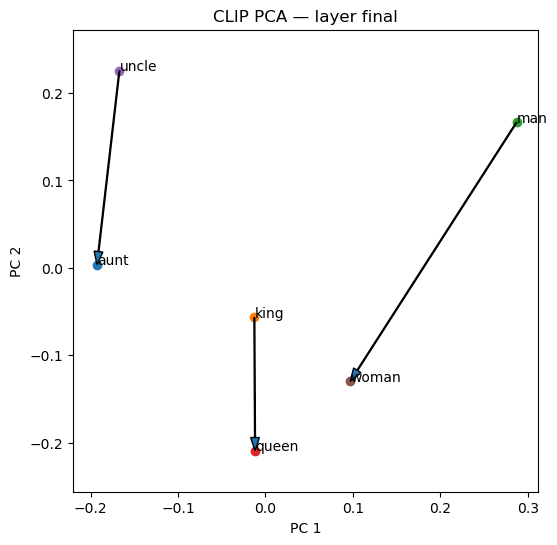

,queen-king,woman-man,aunt-uncle
queen-king,1.000,0.326,0.452
woman-man,0.326,1.000,0.253
aunt-uncle,0.452,0.253,1.000


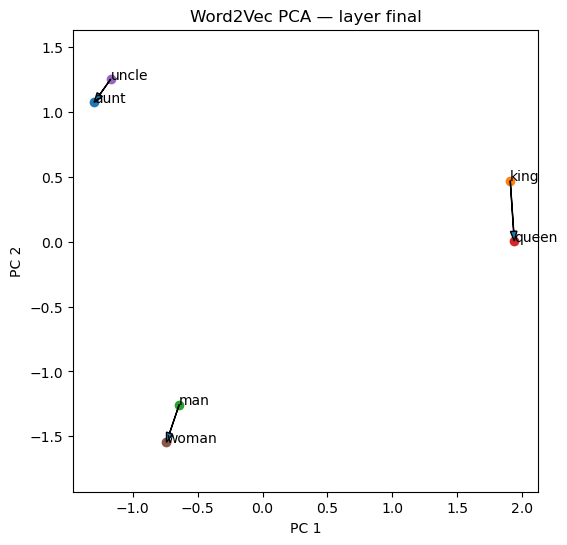

,queen-king,woman-man,aunt-uncle
queen-king,1.000,0.449,0.387
woman-man,0.449,1.000,0.529
aunt-uncle,0.387,0.529,1.000


In [5]:
def run(layer_index: Optional[int] = None) -> None:
    """Execute the minimal pipeline for a given CLIP layer."""
    # CLIP
    clip_emb = collect_clip_embeddings(WORDS, clip_model, layer_idx=layer_index)
    title = f"CLIP PCA — layer {'final' if layer_index is None else layer_index}"
    plot_pca(WORDS, clip_emb, title=title)
    display(pair_similarity_matrix(clip_emb.diffs).style.format("{:.3f}").set_caption(title + " | diff-vector cosine(sim)"))

    # Word2Vec
    w2v_emb = collect_w2v_embeddings(WORDS, kv)
    title = f"Word2Vec PCA — layer {'final' if layer_index is None else layer_index}"
    plot_pca(WORDS, w2v_emb, title=title, head_width=0.05)
    display(pair_similarity_matrix(w2v_emb.diffs).style.format("{:.3f}").set_caption("Word2Vec | diff-vector cosine(sim)"))

# Run once with final layer
run(layer_index=None)

In [6]:
if widgets is not None and display is not None:
    print("Use the dropdown to select a CLIP layer (0-based), or 'final'.")        
    options = [str(i) for i in range(NUM_LAYERS)] + ["final"]
    layer_dropdown = widgets.Dropdown(options=options, value="final", description="Layer:")

    out = widgets.Output()

    def _on_change(change):
        if change.get("name") == "value" and change.get("new") is not None:
            with out:
                clear_output(wait=True)
                layer_idx = None if layer_dropdown.value == "final" else int(layer_dropdown.value)
                run(layer_index=layer_idx, use_w2v=USE_WORD2VEC)

    layer_dropdown.observe(_on_change)
    display(layer_dropdown)
    display(out)
else:
    print("ipywidgets not available. To change layer, call: run(layer_index=<int or None>)")

Use the dropdown to select a CLIP layer (0-based), or 'final'.


Dropdown(description='Layer:', index=12, options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'…

Output()